In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

root_folder = Path().absolute().parent / "experiments" 

# Get latest generated folder
subfolder_list = [f for f in root_folder.iterdir()]
subfolder_list_creation_time = [f.stat().st_ctime for f in subfolder_list]
latest_subfolder_idx =  subfolder_list_creation_time.index(max(subfolder_list_creation_time))
experiment_path = subfolder_list[latest_subfolder_idx]

# Read CSV results
df = pd.read_csv(experiment_path / "results.csv")


In [7]:
# Config file
with open(experiment_path / "config.yml") as f:
     print(f.read())

experiment_name: seqseq
n_repeats: 10
scenario_params_list:
 - partners_count: 
     - 4
   amounts_per_partner: 
     - [0.3, 0.3, 0.2, 0.2]
   samples_split_option: 
     - 'stratified'
   multi_partner_learning_approach:
     - 'fedavg'
     - 'seq-pure'
     - 'seq-with-final-agg'
     - 'seqavg'
   aggregation_weighting: 
     - 'uniform' 
   epoch_count: 
     - 50
   minibatch_count: 
     - 1
     - 2
     - 5
     - 10


In [8]:
scenario_ids = df.scenario_id.unique()
random_states = df.random_state.unique()
samples_split_options = df.samples_split_option.unique()
amounts_per_partner_list = df.amounts_per_partner.unique()

print('Random state', random_states)
print('Scenario id', scenario_ids)
print('amounts_per_partner', amounts_per_partner_list)
print()

df.info()


Random state [0 1 2 3 4 5 6 7 8 9]
Scenario id [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
amounts_per_partner ['[0.3, 0.3, 0.2, 0.2]']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 22 columns):
aggregation_weighting              160 non-null object
amounts_per_partner                160 non-null object
dataset_name                       160 non-null object
epoch_count                        160 non-null float64
final_relative_nb_samples          160 non-null object
gradient_updates_per_pass_count    160 non-null float64
is_early_stopping                  160 non-null float64
learning_computation_time_sec      160 non-null float64
minibatch_count                    160 non-null float64
mpl_nb_epochs_done                 160 non-null float64
mpl_test_score                     160 non-null float64
multi_partner_learning_approach    160 non-null object
nb_samples_used                    160 non-null float64
partners_count               

In [9]:
df["computation_time_minutes"] = df.learning_computation_time_sec / 60
df.short_scenario_name = df.samples_split_option + df.amounts_per_partner + ' mb ' + df.minibatch_count.astype(str)
df.short_scenario_name.unique()
#df.contributivity_method = df.contributivity_method.str.replace('values', '')

array(['stratified[0.3, 0.3, 0.2, 0.2] mb 1.0',
       'stratified[0.3, 0.3, 0.2, 0.2] mb 2.0',
       'stratified[0.3, 0.3, 0.2, 0.2] mb 5.0',
       'stratified[0.3, 0.3, 0.2, 0.2] mb 10.0'], dtype=object)

In [10]:
# Helper function for plot
def get_x_tick_amount(df, scenario_id, partners_ids):
    
    x_ticks = []
    for partner_id in partners_ids:
        current_df = df[(df.scenario_id == scenario_id) & (df.partner_id == partner_id)]
        amount = current_df.amount_per_partner.unique()

        assert(len(amount) == 1)
        amount = amount[0]
    
        x_ticks.append('partner_' + str(partner_id) + ' ' + str(amount))
    return x_ticks

################################################
[0.3, 0.3, 0.2, 0.2]


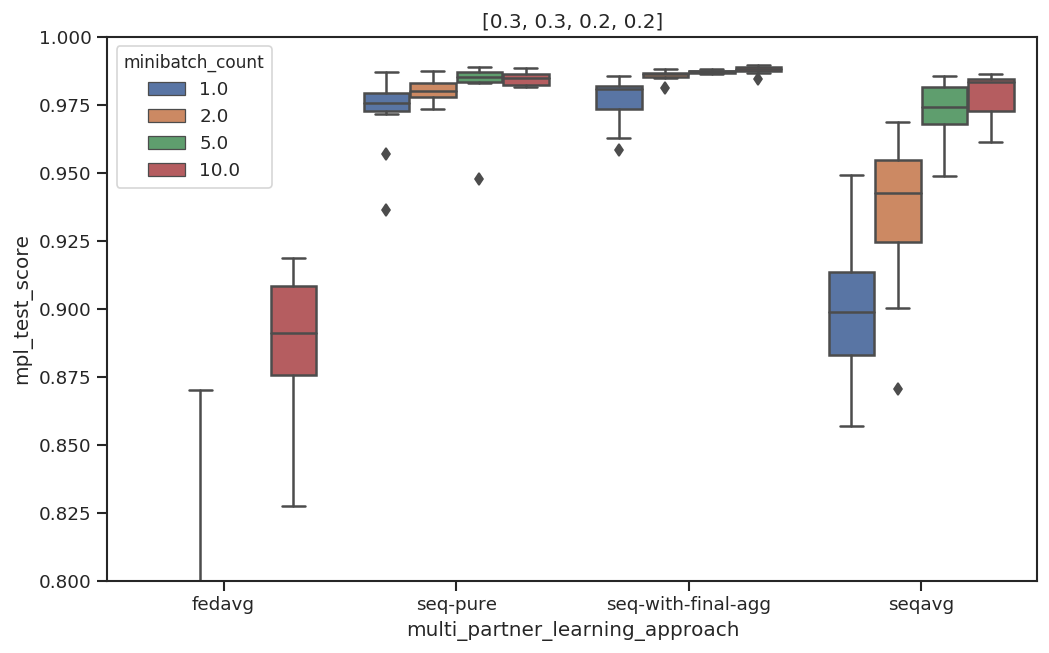

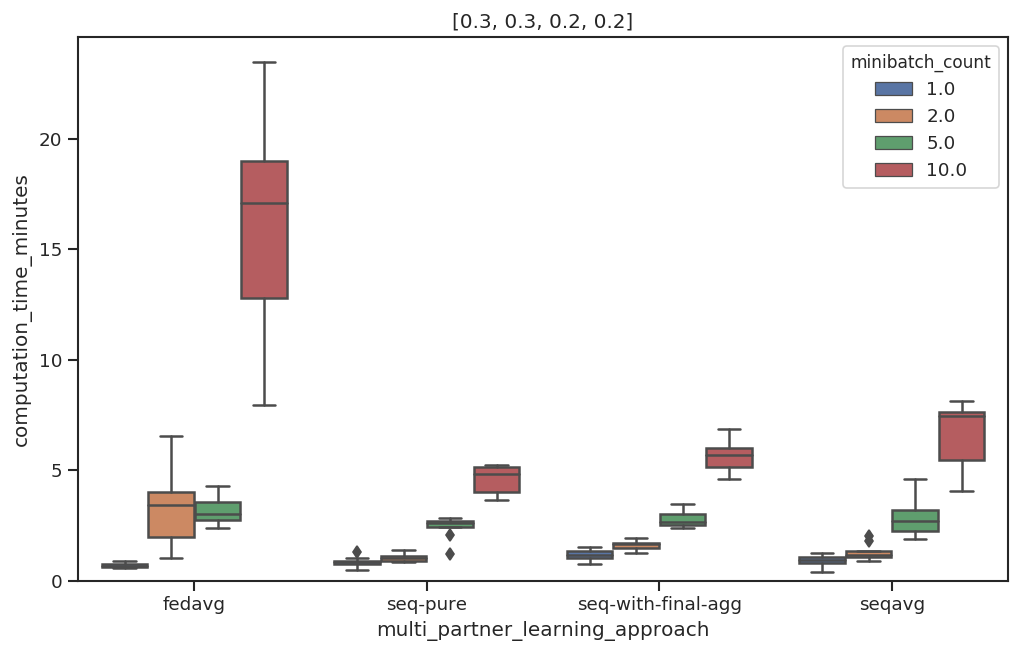

In [11]:
# Plot loop
for amounts_per_partner in amounts_per_partner_list:
    
    current_df = df[df.amounts_per_partner == amounts_per_partner]

    sns.set(style="ticks")
    #current_df.info()
    print("################################################")
    print(amounts_per_partner)

    plt.figure(figsize=(10, 6), dpi=120)
    plt.title(amounts_per_partner)
    ax = sns.boxplot(x="multi_partner_learning_approach", y="mpl_test_score", hue="minibatch_count",
                       data=current_df)
    plt.ylim([0.8, 1])

        
    ax = plt.figure(figsize=(10, 6), dpi=120)
    plt.title(amounts_per_partner)
    sns.boxplot(x="multi_partner_learning_approach", y="computation_time_minutes", hue="minibatch_count",
                     data=current_df)
    plt.ylim(bottom=0)

    
    plt.show()
    

## Losses

In [12]:
df_seq = df[(df.multi_partner_learning_approach == "seq-pure") & (df.minibatch_count == 1)]
df_seq.head(20)


,aggregation_weighting,amounts_per_partner,dataset_name,epoch_count,final_relative_nb_samples,gradient_updates_per_pass_count,is_early_stopping,learning_computation_time_sec,minibatch_count,mpl_nb_epochs_done,...,partners_count,samples_split_option,scenario_name,short_scenario_name,single_partner_test_mode,test_data_samples_count,train_data_samples_count,random_state,scenario_id,computation_time_minutes
4,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,49.669044,1.0,28.0,...,4.0,stratified,scenario_5_repeat_1_2020-06-04_18h54_478,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,0,4,0.827817
20,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,46.559222,1.0,26.0,...,4.0,stratified,scenario_5_repeat_2_2020-06-04_19h50_ae1,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,1,4,0.775987
36,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,78.072204,1.0,44.0,...,4.0,stratified,scenario_5_repeat_3_2020-06-04_20h41_7f6,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,2,4,1.301203
52,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,53.513738,1.0,30.0,...,4.0,stratified,scenario_5_repeat_4_2020-06-04_21h38_01c,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,3,4,0.891896
68,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,60.512687,1.0,35.0,...,4.0,stratified,scenario_5_repeat_5_2020-06-04_22h33_27d,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,4,4,1.008545
84,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,54.402819,1.0,30.0,...,4.0,stratified,scenario_5_repeat_6_2020-06-04_23h20_695,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,5,4,0.906714
100,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,32.032839,1.0,18.0,...,4.0,stratified,scenario_5_repeat_7_2020-06-05_00h12_c50,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,6,4,0.533881
116,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,29.556117,1.0,16.0,...,4.0,stratified,scenario_5_repeat_8_2020-06-05_01h05_1c7,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,7,4,0.492602
132,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,42.829409,1.0,24.0,...,4.0,stratified,scenario_5_repeat_9_2020-06-05_02h04_d37,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,8,4,0.713823
148,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,50.529784,1.0,28.0,...,4.0,stratified,scenario_5_repeat_10_2020-06-05_03h10_a6d,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,9,4,0.842163


In [13]:
pd.set_option('display.max_seq_items', 40)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 30)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', None)


len(df_seq.scenario_name.unique())
df_seq

,aggregation_weighting,amounts_per_partner,dataset_name,epoch_count,final_relative_nb_samples,gradient_updates_per_pass_count,is_early_stopping,learning_computation_time_sec,minibatch_count,mpl_nb_epochs_done,...,partners_count,samples_split_option,scenario_name,short_scenario_name,single_partner_test_mode,test_data_samples_count,train_data_samples_count,random_state,scenario_id,computation_time_minutes
4,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,49.669044,1.0,28.0,...,4.0,stratified,scenario_5_repeat_1_2020-06-04_18h54_478,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,0,4,0.827817
20,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,46.559222,1.0,26.0,...,4.0,stratified,scenario_5_repeat_2_2020-06-04_19h50_ae1,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,1,4,0.775987
36,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,78.072204,1.0,44.0,...,4.0,stratified,scenario_5_repeat_3_2020-06-04_20h41_7f6,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,2,4,1.301203
52,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,53.513738,1.0,30.0,...,4.0,stratified,scenario_5_repeat_4_2020-06-04_21h38_01c,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,3,4,0.891896
68,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,60.512687,1.0,35.0,...,4.0,stratified,scenario_5_repeat_5_2020-06-04_22h33_27d,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,4,4,1.008545
84,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,54.402819,1.0,30.0,...,4.0,stratified,scenario_5_repeat_6_2020-06-04_23h20_695,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,5,4,0.906714
100,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,32.032839,1.0,18.0,...,4.0,stratified,scenario_5_repeat_7_2020-06-05_00h12_c50,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,6,4,0.533881
116,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,29.556117,1.0,16.0,...,4.0,stratified,scenario_5_repeat_8_2020-06-05_01h05_1c7,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,7,4,0.492602
132,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,42.829409,1.0,24.0,...,4.0,stratified,scenario_5_repeat_9_2020-06-05_02h04_d37,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,8,4,0.713823
148,uniform,"[0.3, 0.3, 0.2, 0.2]",MNIST,50.0,"[0.3, 0.3, 0.2, 0.2]",8.0,1.0,50.529784,1.0,28.0,...,4.0,stratified,scenario_5_repeat_10_2020-06-05_03h10_a6d,"stratified[0.3, 0.3, 0.2, 0.2] mb 1.0",global,10000.0,48000.0,9,4,0.842163


In [14]:
scenario_name = df_seq.scenario_name.iloc[0]
scenario_path = experiment_path / scenario_name
history_data_path = scenario_path / "history_data.p"

In [15]:
with open(history_data_path, 'rb') as f:
    loss_data = pickle.load(f)

In [16]:
loss_data.keys()

dict_keys(['loss_collective_models', 'score_matrix_per_partner', 'score_matrix_collective_models'])

In [17]:
score_matrix_per_partner = loss_data["score_matrix_per_partner"]
score_matrix_per_partner.shape

(50, 1, 4)

Text(0, 0.5, 'Local validation score')

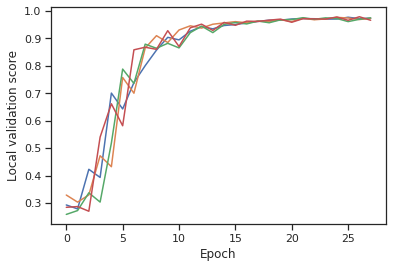

In [18]:
score_matrix_per_partner[score_matrix_per_partner == 0] = 'nan'

partner_idx = 0
plt.plot(score_matrix_per_partner[:, 0, :])
plt.xlabel("Epoch")
plt.ylabel("Local validation score")

(50, 2)


Text(0, 0.5, 'Global validation score')

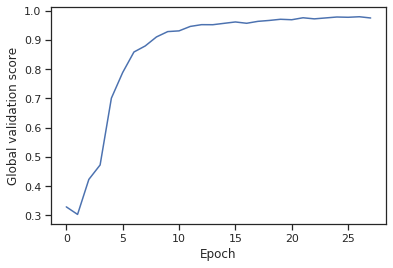

In [19]:
score_matrix_collective_models = loss_data["score_matrix_collective_models"]
print(score_matrix_collective_models.shape)
score_matrix_collective_models[score_matrix_collective_models == 0] = 'nan' # TODO don't init with zero

plt.plot(score_matrix_collective_models[:, 1])
plt.xlabel("Epoch")
plt.ylabel("Global validation score")


Text(0, 0.5, 'Global loss')

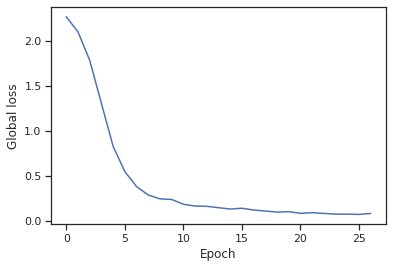

In [20]:
loss_collective_models = loss_data["loss_collective_models"]
loss_collective_models =loss_collective_models[1:] # TODO Why first loss is nan ?
plt.plot(np.arange(len(loss_collective_models)), loss_collective_models)
plt.xlabel("Epoch")
plt.ylabel("Global loss")